In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

In [2]:
sci = pd.read_pickle('../Data/Scientific-Discourse/env_sci.pkl')
wos = pd.read_pickle('../Data/WoS/wos_processed.pkl')

In [3]:
sci = sci[sci.year <= 2021]
wos['year'] = wos.pubyear

### I need sentences

In [4]:
import pandas as pd
import ast
import dask.dataframe as dd
from gensim.utils import effective_n_jobs
import spacy
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

path = 'Environmental Discourse'

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner", "lemmatizer"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

def ngram_tagger(tokens):
    n = len(tokens)
    i = 0
    tokens_q = []
    tokens_qt = []
    tokens_qtb = []
    
    # quadgrams
    while i < n:
        words = '_'.join(tokens[i:i+4])
        if words in quadgrams:
            tokens_q.append(words)
            i += 4
        else:
            tokens_q.append(tokens[i])
            i += 1
    
    # trigrams
    n = len(tokens_q)
    i = 0
    while i < n:
        words = '_'.join(tokens_q[i:i+3])
        if words in trigrams:
            tokens_qt.append(words)
            i += 3
        else:
            tokens_qt.append(tokens_q[i])
            i += 1
    
    # bigrams
    n = len(tokens_qt)
    i = 0
    while i < n:
        words = '_'.join(tokens_qt[i:i+2])
        if words in bigrams:
            tokens_qtb.append(words)
            i += 2
        else:
            tokens_qtb.append(tokens_qt[i])
            i += 1
    
    return tokens_qtb

def sent_tokenize(word_list, model=nlp):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

quadgrams = [('intergovernmental', 'panel', 'climate', 'change'),
             ('natural', 'resources', 'defense', 'council'),
             ('coal', 'fired', 'power', 'plants'),
             ('national', 'oceanic', 'atmospheric', 'administration')]

tr = pd.read_csv('../Data/' + path + '/trigrams.csv', converters={'Unnamed: 0': ast.literal_eval})
tr.columns = ['trigram', 'freq', 'tag']
trigrams = [t for t in tr[tr.tag == 1].trigram]

b = pd.read_csv('../Data/' + path + '/bigrams.csv', converters={'Unnamed: 0': ast.literal_eval})
b.columns = ['bigram', 'freq', 'tag']
bigrams = [t for t in b[b.tag == 1].bigram]

quadgrams = ['_'.join(t) for t in quadgrams]
trigrams = ['_'.join(t) for t in trigrams]
bigrams = ['_'.join(t) for t in bigrams]

/home/mcpackard/anaconda3/envs/thesis/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [5]:
d_sci = dd.from_pandas(sci, npartitions=effective_n_jobs(-1))
d_sci['sents'] = d_sci.text.map(lambda x: [ngram_tagger(
                                           normalizeTokens(
                                           word_tokenize(s), lemma=True)) for s in sent_tokenize(x)])
d_sci['sents'] = d_sci.sents.map(lambda x: [s for s in x if len(s)>0])
sci = d_sci.compute()

In [7]:
sci.to_pickle('../Data/Scientific-Discourse/env_sci_sents.pkl')

### Now do the wordclouds?

In [9]:
def get_adjacent_words(word, data):
    '''
    Data to be provided as a list of lists.
    '''
    after = []
    before = []

    for word_list in data:
        for i, w in enumerate(word_list):
            if w == word:
                if i < len(word_list) - 1:
                    after.append(word_list[i+1])
                if i > 0:
                    before.append(word_list[i-1])
    
    return pd.Series(before).value_counts(), pd.Series(after).value_counts()

In [10]:
yr = 2005
df = sci[sci.year == 2005]

In [17]:
df['sents_w_activi'] = df.sents.apply(lambda x: [s for s in x if 'activist' in s or 'activism' in s])

/tmp/ipykernel_3738/552280463.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
len(df.sents_w_activi.sum())

7

In [16]:
activi = [s for d in df.sents for s in d if 'activism' in s or 'activist' in s]

In [31]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [33]:
stop = ['activism', 'activist']

05 - 06
18 sentences


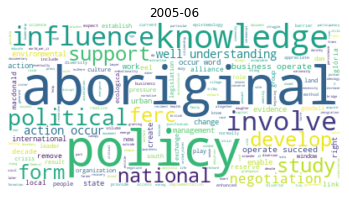

07 - 08
31 sentences


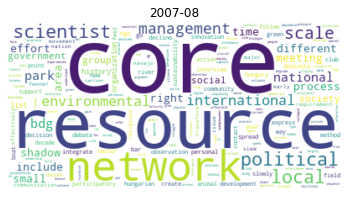

09 - 10
9 sentences


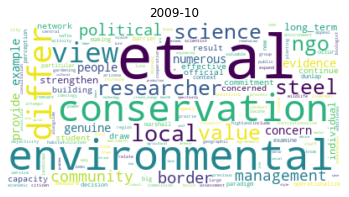

11 - 12
25 sentences


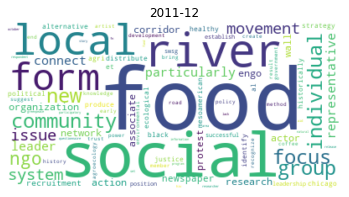

13 - 14
26 sentences


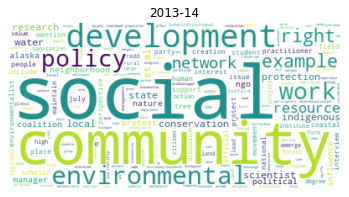

15 - 16
94 sentences


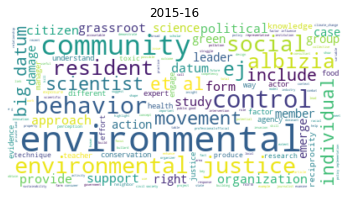

17 - 18
195 sentences


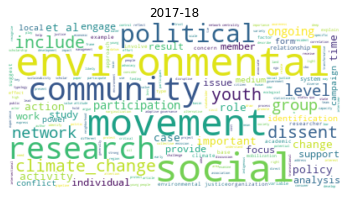

19 - 20
53 sentences


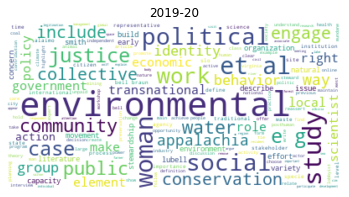

In [35]:
for yr in range(5, 21, 2):
    s_yr = str(yr)
    s_yr2 = str(yr + 1)
    if len(s_yr) == 1:
        s_yr = '0' + s_yr
    if len(s_yr2) == 1:
        s_yr2 = '0' + s_yr2

    print(s_yr, '-', s_yr2)
    df = sci.copy()[(sci.year == 2000 + yr) | (sci.year == yr + 2001)]
    df['sents_w_activi'] = df.sents.apply(lambda x: [s for s in x if 'activist' in s or 'activism' in s])
    print(len(df.sents_w_activi.sum()), "sentences")
    
    lst = [w for s in df.sents_w_activi.sum() for w in s if w not in stop]
    text = ' '.join(lst)
    wc = WordCloud(background_color='white').generate(text)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('20'+s_yr+ '-'+s_yr2)
    plt.show()

In [23]:
df = sci[(sci.year == 2005) | (sci.year == 2006)]
df['sents_w_activi'] = df.sents.apply(lambda x: [s for s in x if 'activist' in s or 'activism' in s])

/tmp/ipykernel_3738/3691254920.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
print(len(df.sents_w_activi.sum()), "sentences")

18 sentences
